## **Problem: Face Mask Detection**

Since the arrival of Covid-19 more than two years ago, the world has been adapting on a daily basis to limit the spread of the epidemic and to protect the most vulnerable people. 
The virus has changed our way of life and wearing a mask has become a habit for all citizens. 
Until recently, it was even compulsory to wear one in public places. The number of daily cases has now fallen, especially with the advent of the vaccine, and masks are no longer required in most countries. However, some countries are still experiencing large numbers of cases and deaths, and no country is immune to a possible resurgence of cases. 
A new wave is likely to come, so it is important to anticipate it by being as prepared as possible. This is how I came up with the idea of building a model based on a convolutional neural network capable of detecting when a person is wearing a mask.

The objective of this project is to detect whether a person is wearing the mask or not, and if so, whether he or she is wearing it in the right way. There are three classes that make up the dataset, a class of people who wear the mask well, a class of people who wear the mask poorly and a class of people who do not wear the mask.

### About this dataset

The dataset is divided into three folders of images. The first folder with_mask contains 3725 images of people wearing the mask. The second folder without_mask contains 3828 images of people not wearing masks. The third folder badly_worn contains 2844 images of people wearing the mask incorrectly. Thus, the complete dataset contains 10397 images.

#### Dataset attributions

Source : 

https://www.kaggle.com/datasets/omkargurav/face-mask-dataset 

https://github.com/cabani/MaskedFace-Net

In [ ]:
#import

import os, shutil

import tensorflow as tf 
from tensorflow import keras 

import random
from random import seed
from random import randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


### **Step 1: Data preprocessing and visualization**

###### **Data Preparation**

**Importing data into Google Colab**

Loading the dataset from Google Drive.

In [ ]:
#FOR GOOGLE COLAB ONLY

#import dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the data set of badly worn masks**

https://github.com/cabani/MaskedFace-Net

The complete dataset contains 66,734 images.
For practical purposes, 2844 are preselected.

Transfer the images to the main dataset within the badly_worn folder.

In [ ]:
#FOR GOOGLE COLAB ONLY
src = '/content/drive/MyDrive/ML/badly_worn'
dest =  '/content/drive/MyDrive/ML/data/'
shutil.move(src, dest)

In [ ]:
#ELSE
src = '/badly_worn'
dest =  '/data/'
shutil.move(src, dest)

###### **Data loading**

In [ ]:
#FOR GOOGLE COLAB ONLY
dir="/content/drive/MyDrive/ML/data"
classes = os.listdir(dir)
classes

['badly_worn', 'with_mask', 'without_mask']

In [ ]:
#ELSE
dir="/data"
classes = os.listdir(dir)
classes

In [ ]:
x,y =[],[]
for clas in classes:
    path=os.path.join(dir,clas)
    for img in os.listdir(path):
        x.append(plt.imread(os.path.join(path,img)))
        y.append(str(clas))

In [ ]:
(listImg, listLabels) = (pd.Series(x, name="Img"), pd.Series(y, name="label"))

ds = pd.concat([listImg,listLabels], axis=1)
maskDF = pd.DataFrame(ds)

print(maskDF["label"].value_counts())

without_mask    3828
with_mask       3725
badly_worn      2844
Name: label, dtype: int64


###### **Exploration des données**

In [ ]:
maskDF.shape

(10397, 2)

In [ ]:
maskDF.columns

Index(['Img', 'label'], dtype='object')

In [ ]:
print(maskDF.head())

                                                 Img       label
0  [[[246, 246, 246], [246, 246, 246], [246, 246,...  badly_worn
1  [[[130, 147, 163], [129, 146, 164], [128, 145,...  badly_worn
2  [[[229, 227, 228], [229, 227, 228], [229, 227,...  badly_worn
3  [[[199, 199, 199], [199, 199, 199], [199, 199,...  badly_worn
4  [[[173, 83, 31], [177, 87, 35], [170, 80, 28],...  badly_worn


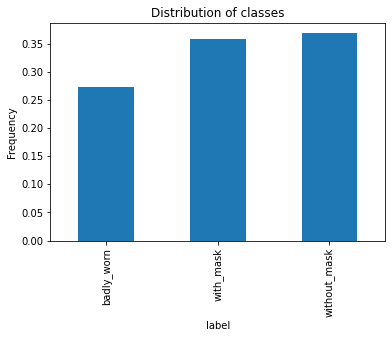

In [ ]:
(maskDF.groupby('label').size()/len(maskDF) ).plot(kind='bar')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

In [ ]:
maskDF.isnull().sum(axis=0)

Img      0
label    0
dtype: int64

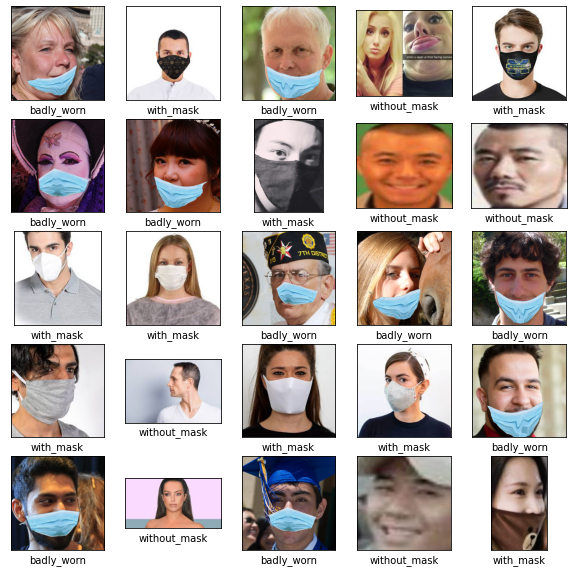

In [ ]:
#Show (RANDOM) 25 images in the dataset
plt.figure(figsize=(10,10))
seed(123)
for i in range(25):
    value = randint(0, len(maskDF))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(maskDF.Img[value])
    plt.xlabel(maskDF.label[value])
plt.show()

In [ ]:
#Remove the previous variables !
x = []
y = []
ds = []
maskDF = []

### **Step 2: Model training and evaluation**

###### **Preparation of the folder Test**

**Separation of 10% of the dataset in a Test folder**

The total dataset has 10397 images, 10% of them are selected (i.e. 1040 images) and moved to the Test folder.

According to the graph of the data by class, about 30% of the dataset is composed of badly_worn images, about 35% of the dataset is composed of images with_mask and also 35% for without_mask.

We choose (randomly) 312 (1040 * 0.3) images from the folder badly_worn, 364 (1040 * 0.35) images from the folder with_mask, and 364 (1040 * 0.35) images from the folder without_mask

In [ ]:
#FOR GOOGLE COLAB ONLY

dest_test="/content/drive/MyDrive/ML/test"

In [ ]:
#ELSE

dest_test="/test"

In [ ]:
os.makedirs(dest_test)

for cls in classes:
  ext = '/' + cls
  os.makedirs(dest_test + ext)

  if cls == 'badly_worn':
    size = 312
  else: 
    size = 364

  src_allImg = dir + ext
  for i in range(size):
    img = random.choice(os.listdir(src_allImg))
    src_test = dir + ext + '/' + img
    shutil.move(src_test, dest_test + ext)

###### **Train-test split**

In [ ]:
batch_size = 32
img_height = 150
img_width = 150

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.11,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9357 files belonging to 3 classes.
Using 8328 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir,
  validation_split=0.11,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9357 files belonging to 3 classes.
Using 1029 files for validation.


In [ ]:
#FOR GOOGLE COLAB ONLY

#Path to the Test folder
dir_test="/content/drive/MyDrive/ML/test"

In [ ]:
#ELSE

#Path to the Test folder
dir_test="/test"

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_test,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1040 files belonging to 3 classes.


In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

###### **Implémentation du modèle**

In [ ]:
model = keras.Sequential([
                          #normalization of data between [0, 1] 
                          keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                          #First convolution layer: 128 neurons, activ. relu
                          keras.layers.Conv2D(128, 4, activation="relu"),
                          #pooling layer -> Max pooling 
                          keras.layers.MaxPooling2D(),
                          #Second convolution layer: 64 neurons, activ. relu
                          keras.layers.Conv2D(64, 4, activation="relu"),
                          #pooling layer -> Max pooling 
                          keras.layers.MaxPooling2D(),
                          #Third convolution layer: 32 neurons, activ. relu
                          keras.layers.Conv2D(32, 4, activation="relu"),
                          #pooling layer -> Max pooling 
                          keras.layers.MaxPooling2D(),
                          #Fourth convolution layer: 16 neurons, activ. relu
                          keras.layers.Conv2D(16, 4, activation="relu"),
                          #pooling layer -> Max pooling 
                          keras.layers.MaxPooling2D(),
                          #Flattening
                          keras.layers.Flatten(),
                          keras.layers.Dense(64,activation="relu"),
                          #Output layer : 3 neurons (nb of classes)
                          keras.layers.Dense(3,activation="softmax")
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 147, 147, 128)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 64)        131136    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        3

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
261/261 [==============================] - 214s 714ms/step - loss: 0.3551 - accuracy: 0.8543 - val_loss: 0.2190 - val_accuracy: 0.9174
Epoch 2/50
261/261 [==============================] - 175s 670ms/step - loss: 0.1992 - accuracy: 0.9304 - val_loss: 0.2163 - val_accuracy: 0.9232
Epoch 3/50
261/261 [==============================] - 177s 676ms/step - loss: 0.1590 - accuracy: 0.9440 - val_loss: 0.1273 - val_accuracy: 0.9553
Epoch 4/50
261/261 [==============================] - 182s 698ms/step - loss: 0.1414 - accuracy: 0.9500 - val_loss: 0.1229 - val_accuracy: 0.9602
Epoch 5/50
261/261 [==============================] - 191s 730ms/step - loss: 0.1233 - accuracy: 0.9582 - val_loss: 0.1160 - val_accuracy: 0.9650
Epoch 6/50
261/261 [==============================] - 182s 697ms/step - loss: 0.1112 - accuracy: 0.9610 - val_loss: 0.1091 - val_accuracy: 0.9640
Epoch 7/50
261/261 [==============================] - 181s 692ms/step - loss: 0.0912 - accuracy: 0.9697 - val_loss: 0.1159 -

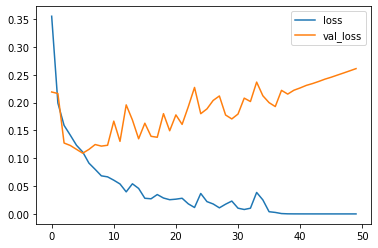

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

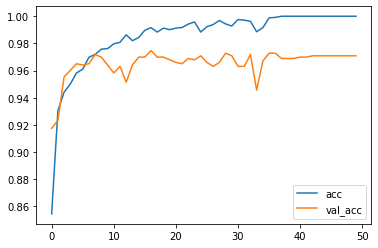

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

###### **Model Evaluation**

In [ ]:
score = model.evaluate(test_ds)

33/33 [==============================] - 11s 253ms/step - loss: 0.2859 - accuracy: 0.9769


In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.28593653440475464
Test accuracy: 0.9769230484962463


In [43]:
predictions = []
label = []
for x, y in test_ds:
  label.append(y)
  predictions.append(np.argmax(model.predict(x), axis = -1))

pred_labels = tf.concat([item for item in predictions], axis = 0)
labels = tf.concat([item for item in label], axis = 0)

In [44]:
#Matrice confusion
from sklearn.metrics import confusion_matrix, classification_report

matrix = confusion_matrix(labels, pred_labels)
df_confusion = pd.DataFrame(matrix, index=['badly_worn','with_mask','without_mask'],columns=['badly_worn','with_mask','without_mask'])

df_confusion

,badly_worn,with_mask,without_mask
badly_worn,310,1,1
with_mask,0,357,7
without_mask,0,15,349


In [45]:
print(classification_report(labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       312
           1       0.96      0.98      0.97       364
           2       0.98      0.96      0.97       364

    accuracy                           0.98      1040
   macro avg       0.98      0.98      0.98      1040
weighted avg       0.98      0.98      0.98      1040



In [48]:
from keras.preprocessing.image import load_img, img_to_array

def predict_class(path):

    img = load_img(path, 
        target_size=(img_height, img_width)
        )
    
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    pred_class = model.predict(img_array)
    proba = tf.nn.softmax(pred_class[0])

    print("Predicted class : {}.".format(classes[np.argmax(proba)]))

Predicted class : badly_worn.


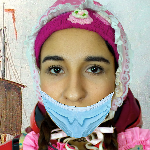

In [49]:
#Test for the badly_worn class

predict_class('/content/drive/MyDrive/IA/test/badly_worn/00004_Mask_Mouth_Chin.jpg')

img = load_img(
    '/content/drive/MyDrive/IA/test/badly_worn/00004_Mask_Mouth_Chin.jpg',
    target_size=(150,150)
    )
img

Predicted class : with_mask.


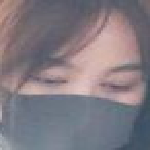

In [50]:
#Test for the with_mask class

predict_class('/content/drive/MyDrive/ML/test/with_mask/with_mask_1121.jpg')

img = load_img(
    '/content/drive/MyDrive/ML/test/with_mask/with_mask_1121.jpg',
    target_size=(150,150)
    )
img

Predicted class : without_mask.


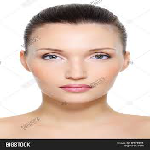

In [51]:
#Test for the without_mask class

predict_class('/content/drive/MyDrive/ML/test/without_mask/without_mask_1089.jpg')

img = load_img(
    '/content/drive/MyDrive/ML/test/without_mask/without_mask_1089.jpg',
    target_size=(150,150)
    )
img